# Drill: Improve the Gradient Boosting Model

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score ,train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]
print(X_train.shape)
print(y_train.shape)
# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]
print(X_test.shape)
print(y_test.shape)

(7332, 16)
(7332,)
(815, 16)
(815,)


In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

print(table_train)
print(table_test)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    '{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    '{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(clf.score(X_train, y_train), train_tI_errors, train_tII_errors, 
         clf.score(X_test, y_test), test_tI_errors, test_tII_errors))



col_0     0.0   1.0   All
partner                  
0.0      4167   341  4508
1.0      1291  1533  2824
All      5458  1874  7332
col_0    0.0  1.0  All
partner               
0.0      454   51  505
1.0      151  159  310
All      605  210  815
Training set accuracy:
0.7774140752864157
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
0.7521472392638037
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

Learning rates vary between 0 (only the initial iteration matters) to 1 (all iterations are weighted equally).  A model made up of many small steps is less prone to overfitting than a model made up of few large steps.

Choosing max_features < n_features leads to a reduction of variance and an increase in bias.

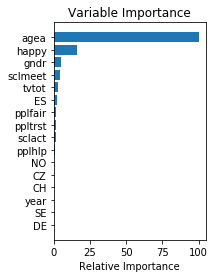

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


Somehow this plot is different than the one on the Thinkful page but we will still go with it. 

With feature importances like the ones above - we can create a binary situation for the categorical variables where anything that is ES=1, and all others=0.  Other options could be combining the pplfair and ppltrust variables to increase their importance.  Creating relationships between the social categories might help as well.

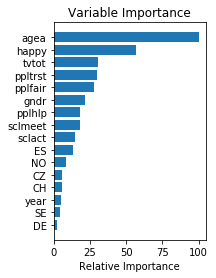

In [45]:
# let's build a function that gives us the information we are looking for and allows us to 
# imput new params and data

def gbm(x, y, 
        n=100, 
        depth=3, 
        lr=0.1, 
        loss='deviance', 
        subsample=1, 
        crossval=False, 
        cv=5,
        max_features=None,
        val_frac=0.1,
        no_change=10, 
        tol=1e-4):
    '''
    Function that runs a Gradient Boosting Classifier and allows for some parameter tuning
    Will score the model and calculate the percentage of type1 and type2 errors
    '''
    # initialize time
    start = time.time()
    # set up parameters - parameters are set to defaults to start
    params = {'n_estimators': n,
              'max_depth': depth,
              'learning_rate': lr,
              'loss': loss, 
              'subsample': subsample,
              'max_features': max_features,
              'validation_fraction': val_frac,
              'n_iter_no_change': no_change, 
              'tol': tol}
    
    # Show the Params for the model
    display(params)
    
    # Initialize and fit the model
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(x, y)

    # Predict model
    predict_train = clf.predict(x)

    # Accuracy tables
    table_train = pd.crosstab(y, predict_train, margins=True)
        
    # Calculate type1 and type2 errors
    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    print((
        'Training set accuracy:\n'
        '{}\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        ).format(clf.score(x, y), train_tI_errors, train_tII_errors))
    
    # Cross Validation
    if crossval==True:
        print(cross_val_score(clf, x, y, cv=cv))
    
    # Get feature importance
    feature_importance = clf.feature_importances_
    
    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    # Get sorted index for feature importances
    sorted_idx = np.argsort(feature_importance)
    
    # Create spacing
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Create plot
    plt.figure(figsize=(4,4))
    plt.barh(pos, feature_importance[sorted_idx])
    plt.yticks(pos, x.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    # Show what iteration we stopped at
    print('Number of iterations before threshold:\n', clf.n_estimators_)
    # stop time
    end = time.time()
    print('Time: {0:0.5f}s '.format(end-start))

{'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'subsample': 1,
 'max_features': None,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7738679759956356
Percent Type I errors: 0.042962356792144024
Percent Type II errors: 0.18316966721222042


[0.62304022 0.48329925 0.76209952 0.74351978 0.76040956]


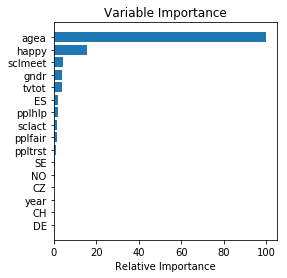

Number of iterations before threshold:
 100
Time: 2.12841s 


In [46]:
# All default parameters
gbm(X_train, y_train, crossval=True)

{'n_estimators': 500,
 'max_depth': 10,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'subsample': 1,
 'max_features': None,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.8636115657392253
Percent Type I errors: 0.0057283142389525366
Percent Type II errors: 0.13066012002182215


[0.62576687 0.48125426 0.7402863  0.72851296 0.74266212]


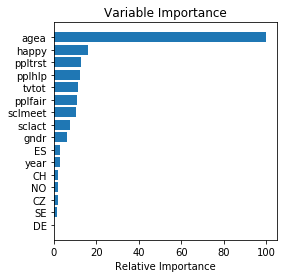

Number of iterations before threshold:
 154
Time: 45.51249s 


In [47]:
# Increasing the max_depth to 10 and decreasing the learning rate to 0.01
# increasing the depth will explain more of the variance but at the expense of likely overfitting
# decreasing the learning rate will help prevent overfitting but also increase the run time

gbm(X_train, y_train, 500, 10, 0.01, 'deviance', 1, crossval=True)

The model does not validate well.  It is clearly overfitting - most likely because the depth is too large.

{'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'subsample': 0.75,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7879159847244953
Percent Type I errors: 0.03150572831423895
Percent Type II errors: 0.18057828696126568


[0.65507839 0.48398091 0.76823449 0.74010914 0.75904437]


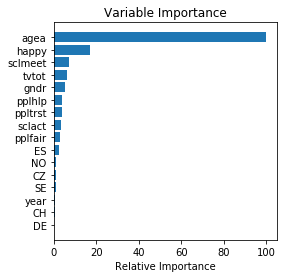

Number of iterations before threshold:
 354
Time: 18.45836s 


In [11]:
# Subsampling now at 75%
# subsampling will make it harder to overfit the data by introducing some more randomness in the model

gbm(X_train, y_train, 500, 5, 0.01, 'deviance', .75, crossval=True)

{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7896890343698855
Percent Type I errors: 0.03136933987997818
Percent Type II errors: 0.1789416257501364


[0.64144513 0.48398091 0.76550784 0.74351978 0.7556314 ]


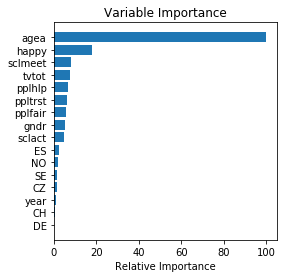

Number of iterations before threshold:
 363
Time: 13.11247s 


In [12]:
# Subsample at 50% and increase the number of iterations

gbm(X_train, y_train, 1000, 5, 0.01, 'deviance', .5, crossval=True)

It appears given that the cross validation is not changing - there may be a sampling issue.  Let's try resampling.

In [13]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(7332, 16)
(7332,)
(815, 16)
(815,)


{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7860065466448445
Percent Type I errors: 0.03464266230223677
Percent Type II errors: 0.1793507910529187


[0.77164281 0.74846626 0.75511596 0.75034106 0.75784447]


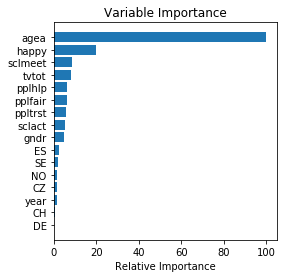

Number of iterations before threshold:
 360
Time: 13.69337s 


In [14]:
gbm(X1_train, y1_train, 1000, 5, 0.01, 'deviance', .5, crossval=True)

{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.8429447852760736
Percent Type I errors: 0.01717791411042945
Percent Type II errors: 0.13987730061349693


[0.75       0.69512195 0.73619632 0.7654321  0.7654321 ]


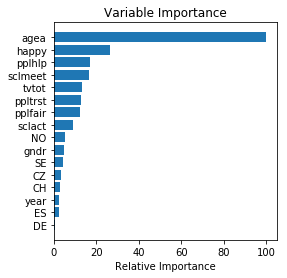

Number of iterations before threshold:
 196
Time: 1.97348s 


In [26]:
gbm(X1_test, y1_test, 1000, 5, 0.01, 'deviance', .5, crossval=True)

Resampling has fixed the issue with the cross validation. Now we do still have some issues as seen in the testing set evaluation.

{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7817785051827605
Percent Type I errors: 0.033960720130932896
Percent Type II errors: 0.1842607746863066


[0.76823449 0.74369461 0.75716235 0.74897681 0.7585266 ]


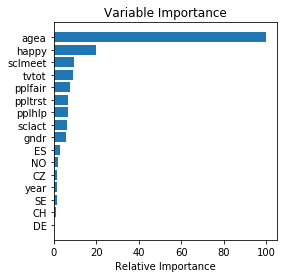

Number of iterations before threshold:
 351
Time: 12.99981s 


In [27]:
# changing loss function to exponential
gbm(X1_train, y1_train, 1000, 5, 0.01, 'exponential', .5, crossval=True)

{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.8196319018404908
Percent Type I errors: 0.0049079754601227
Percent Type II errors: 0.1754601226993865


[0.73170732 0.65853659 0.74846626 0.75925926 0.74691358]


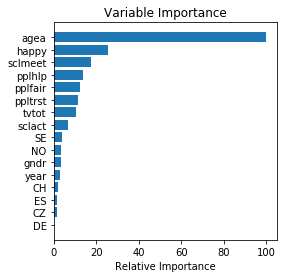

Number of iterations before threshold:
 152
Time: 1.33613s 


In [28]:
gbm(X1_test, y1_test, 1000, 5, 0.01, 'exponential', .5, crossval=True)

It appears we have done better with the exponential loss function but we are still overfitting.

{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.005,
 'loss': 'exponential',
 'subsample': 0.25,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7722313147845062
Percent Type I errors: 0.030278232405891982
Percent Type II errors: 0.19749045280960176


[0.76755283 0.74437628 0.75648022 0.75238745 0.76125512]


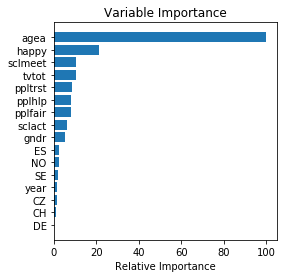

Number of iterations before threshold:
 480
Time: 15.40652s 


In [29]:
# Decrease the learning rate
gbm(X1_train, y1_train, 1000, 5, 0.005, 'exponential', .25, crossval=True)

It seems like it is time to start creating some new features.

In [30]:
corrmatrix = df.drop('idno',1).corr()['partner']
print(corrmatrix.sort_values(ascending=False))

partner    1.000000
sclmeet    0.162970
gndr       0.033984
year       0.018689
sclact     0.011405
pplhlp    -0.022069
tvtot     -0.028816
pplfair   -0.034054
ppltrst   -0.034371
happy     -0.145061
agea      -0.256670
Name: partner, dtype: float64


In [38]:
# New feature creation
features = X.copy()
# Relationships between variables
features['ppltrst_pplfair_pplhlp'] = features['ppltrst']*features['pplfair']*features['pplhlp']
features['sclmeet_sclact'] = features['sclmeet']*features['sclact']
features['happy_tvtot'] = features['happy']*features['tvtot']
features['gndr_year'] = features['gndr']*features['year']

# polynomial relationships with age - most important feature
features['agea_sqrt'] = features['agea']**0.5
features['agea2'] = features['agea']**2
features['agea3'] = features['agea']**3

# Resample the data
Xf_train, Xf_test, yf_train, yf_test = train_test_split(features, 
                                                        (df['partner']-1), 
                                                        train_size=0.9, 
                                                        random_state=42)
print(Xf_train.shape)
print(yf_train.shape)
print(Xf_test.shape)
print(yf_test.shape)

(7332, 23)
(7332,)
(815, 23)
(815,)


{'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.005,
 'loss': 'exponential',
 'subsample': 0.25,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.773595199127114
Percent Type I errors: 0.03136933987997818
Percent Type II errors: 0.1950354609929078


[0.76346285 0.74642127 0.75443383 0.75306958 0.75375171]


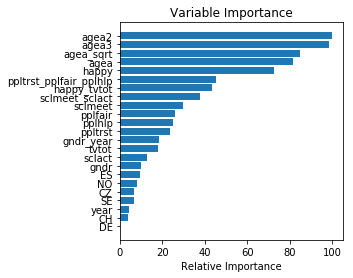

Number of iterations before threshold:
 524
Time: 19.90496s 


In [32]:
# New features and latest parameters
gbm(Xf_train, yf_train, 1000, 5, 0.005, 'exponential', .25, crossval=True)

{'n_estimators': 1000,
 'max_depth': 10,
 'learning_rate': 0.005,
 'loss': 'exponential',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.849836333878887
Percent Type I errors: 0.005591925804691762
Percent Type II errors: 0.14457174031642117


[0.7661895  0.74096796 0.75443383 0.75306958 0.75306958]


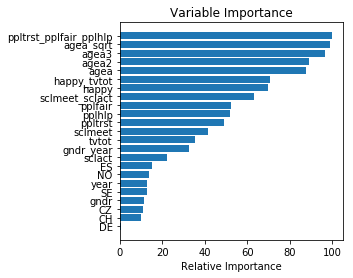

Number of iterations before threshold:
 354
Time: 100.22255s 


In [33]:
# increase max depth
gbm(Xf_train, yf_train, 1000, 10, 0.005, 'exponential', .5, crossval=True)

{'n_estimators': 10000,
 'max_depth': 5,
 'learning_rate': 0.005,
 'loss': 'exponential',
 'subsample': 0.5,
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7801418439716312
Percent Type I errors: 0.031232951445717402
Percent Type II errors: 0.1886252045826514


[0.76687117 0.73755965 0.75648022 0.74897681 0.75579809]


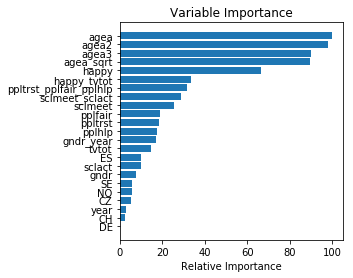

Number of iterations before threshold:
 656
Time: 32.21170s 


In [34]:
# increase iterations
gbm(Xf_train, yf_train, 10000, 5, 0.005, 'exponential', .5, crossval=True)

{'n_estimators': 1000,
 'max_depth': 10,
 'learning_rate': 0.1,
 'loss': 'exponential',
 'subsample': 0.5,
 'max_features': 'sqrt',
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.8385160938352427
Percent Type I errors: 0.015002727768685215
Percent Type II errors: 0.14648117839607203


[0.75528289 0.74846626 0.74079127 0.74283765 0.74624829]


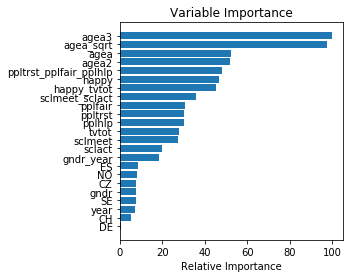

Number of iterations before threshold:
 23
Time: 3.29044s 


In [49]:
gbm(Xf_train, yf_train, 1000, 10, 0.1, 'exponential', .5, crossval=True, max_features='sqrt')

{'n_estimators': 1000,
 'max_depth': 2,
 'learning_rate': 0.1,
 'loss': 'exponential',
 'subsample': 0.5,
 'max_features': 'sqrt',
 'validation_fraction': 0.1,
 'n_iter_no_change': 10,
 'tol': 0.0001}

Training set accuracy:
0.7779141104294478
Percent Type I errors: 0.033128834355828224
Percent Type II errors: 0.18895705521472392


[0.72560976 0.68292683 0.74233129 0.74074074 0.72222222]


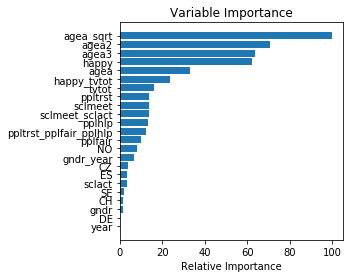

Number of iterations before threshold:
 56
Time: 0.34133s 


In [50]:
gbm(Xf_test, yf_test, 1000, 2, 0.1, 'exponential', .5, crossval=True, max_features='sqrt')

From all of the iterations I have run, I was unable to really bring up the cross validation score.  I played around with the parameters and only ended up overfitting the model.  

With all of the parameters I have tweaked and added to my function, I have been able to keep the computational demand low.  The threshold, validation set, and number of iterations with no change parameters in conjunction with the max features being set to sqrt I have increased the speed of the function and ended up with the same results.  

Not exactly sure what to do about the cross validation.